# Extracting Features
the `extract_features` function extracts 

In [1]:
import os
import librosa
import numpy as np

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, mono=True, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Extract Tonnetz feature (takes too long to compute)
    # tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # Stack the features, then compute their mean and standard deviation
    features = np.vstack([mfcc, spectral_contrast, chroma])#, tonnetz])
    features_mean = np.mean(features, axis=1)
    features_std = np.std(features, axis=1)

    return np.hstack([features_mean, features_std])

In [2]:
data_folder = "Data/genres_original"
genre_folders = os.listdir(data_folder)
labels = []
feature_list = []

!jupyter nbextension enable --py widgetsnbextension

from tqdm.notebook import tqdm

for genre in tqdm(genre_folders, desc="Genres", unit="genre"):
    genre_folder_path = os.path.join(data_folder, genre)
    for file_name in tqdm(os.listdir(genre_folder_path), desc=f"Files in {genre}", unit="file"):
        audio_path = os.path.join(genre_folder_path, file_name)
        try:
            features = extract_features(audio_path)
        except Exception as e:
            print("Error encountered while processing file: ", audio_path)
            continue
        feature_list.append(features)
        labels.append(genre)

# Convert the feature_list and labels to NumPy arrays
X = np.array(feature_list)
y = np.array(labels)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Genres:   0%|          | 0/10 [00:00<?, ?genre/s]

Files in blues:   0%|          | 0/100 [00:00<?, ?file/s]

Files in classical:   0%|          | 0/100 [00:00<?, ?file/s]

Files in country:   0%|          | 0/100 [00:00<?, ?file/s]

Files in disco:   0%|          | 0/100 [00:00<?, ?file/s]

Files in hiphop:   0%|          | 0/100 [00:00<?, ?file/s]

Files in jazz:   0%|          | 0/100 [00:00<?, ?file/s]

C:\Users\USER\AppData\Local\Temp\ipykernel_4712\3339601984.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, mono=True, duration=30)
c:\ProgramData\Anaconda3\envs\personal_ai\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error encountered while processing file:  Data/genres_original\jazz\jazz.00054.wav


Files in metal:   0%|          | 0/100 [00:00<?, ?file/s]

Files in pop:   0%|          | 0/100 [00:00<?, ?file/s]

Files in reggae:   0%|          | 0/100 [00:00<?, ?file/s]

Files in rock:   0%|          | 0/100 [00:00<?, ?file/s]

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

np.save('X.npy', X)
np.save('y_encoded.npy', y_encoded)
# save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)




# Visualization
Wanted to visualize the mfcc, not exactly sure how it works though but I can see how different genres look like


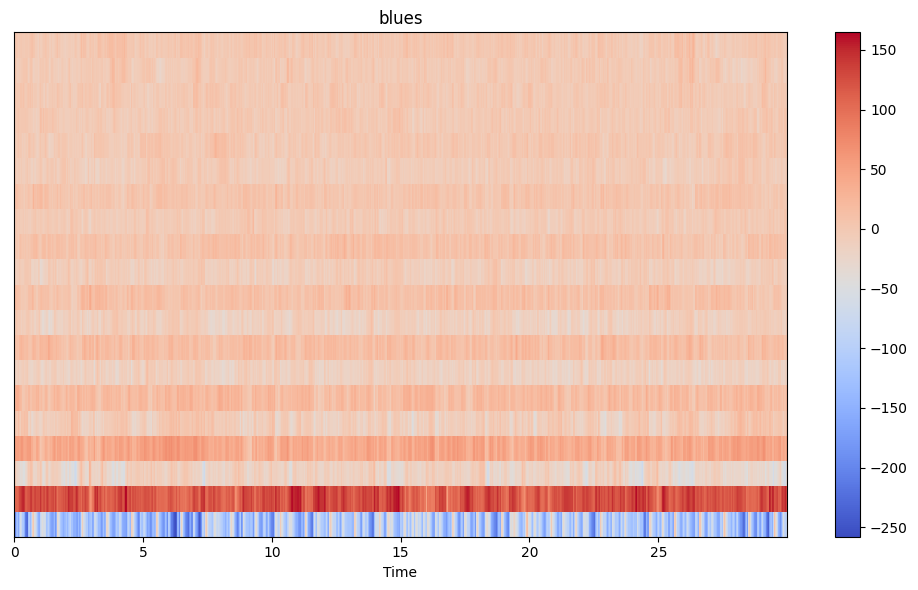

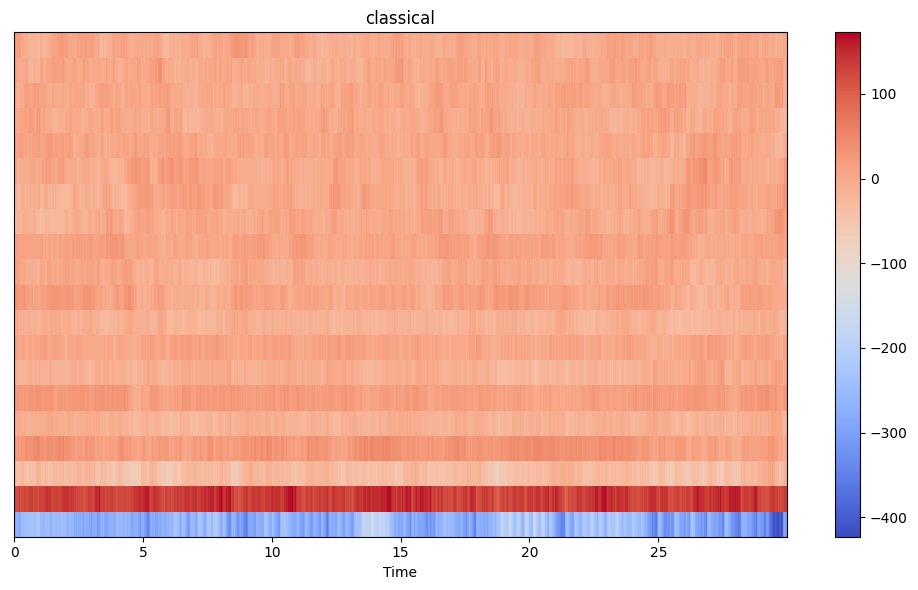

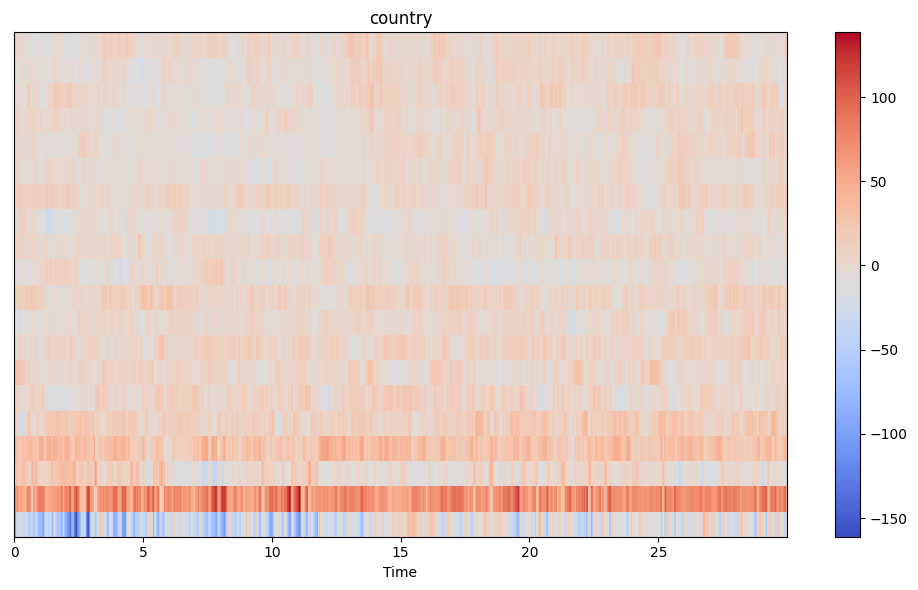

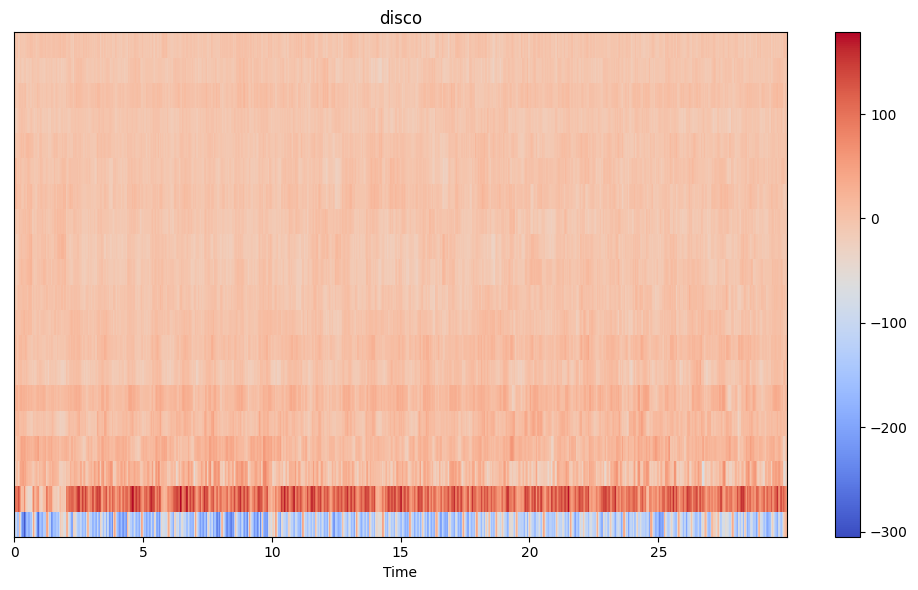

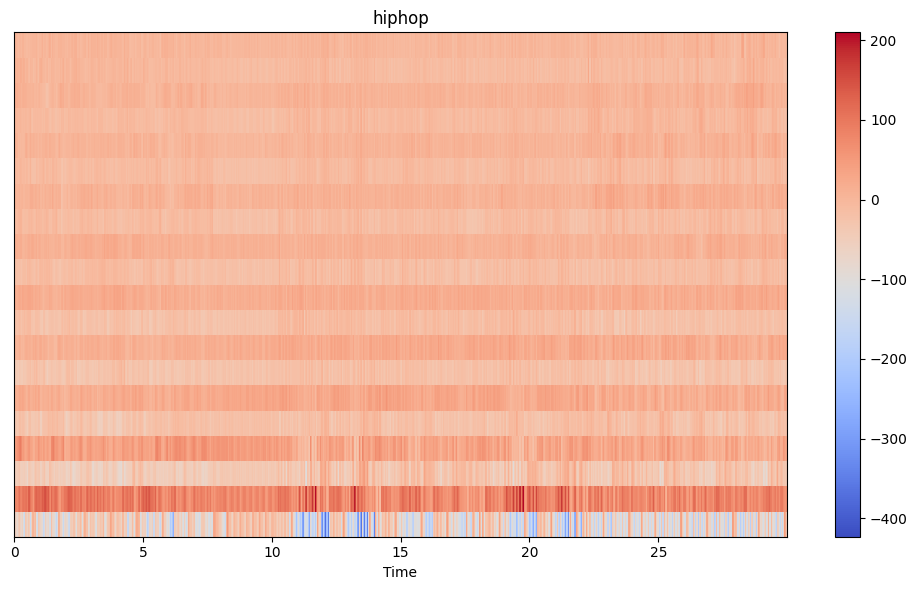

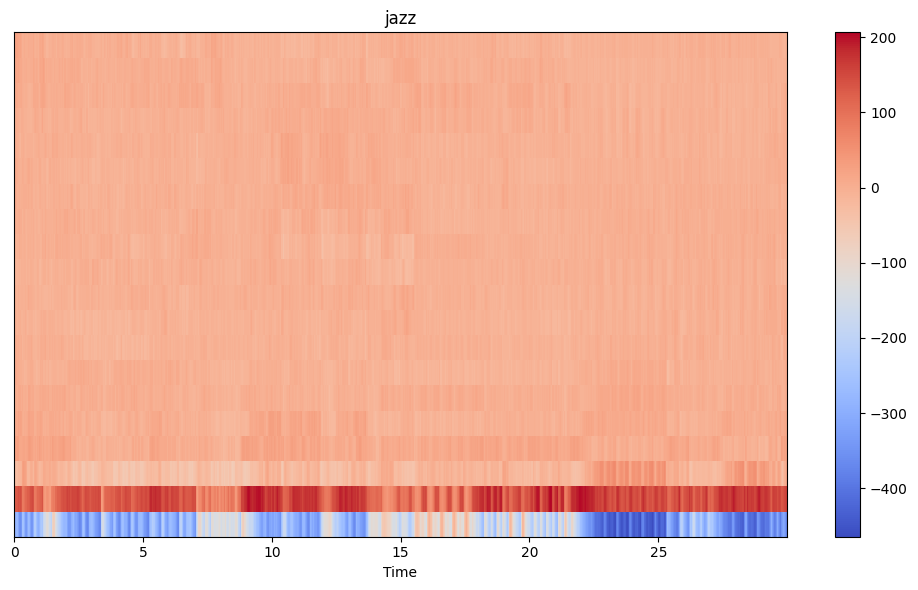

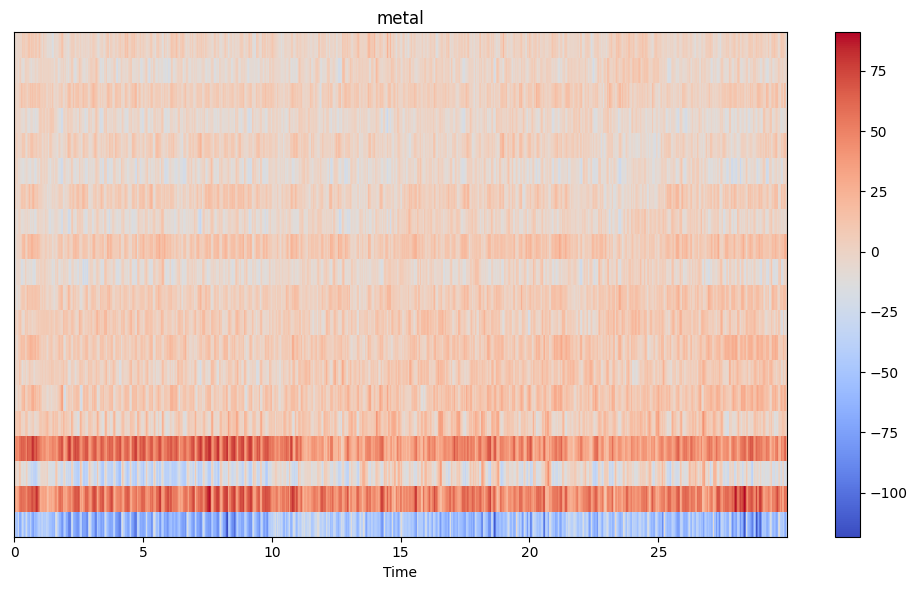

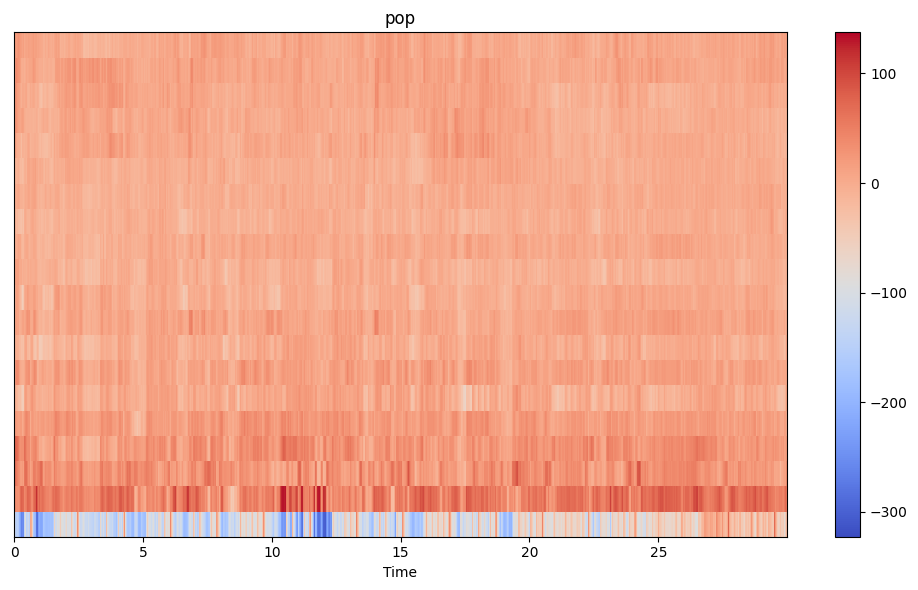

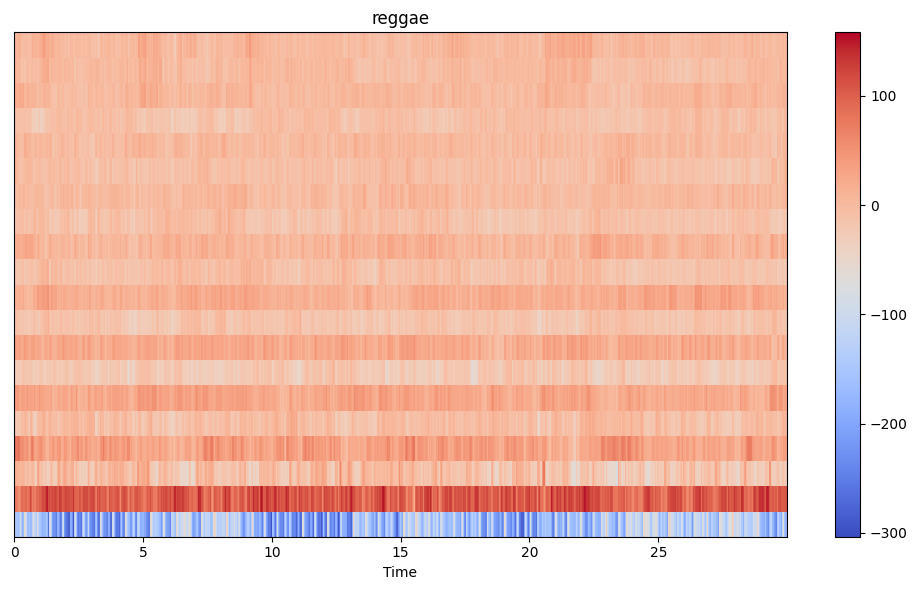

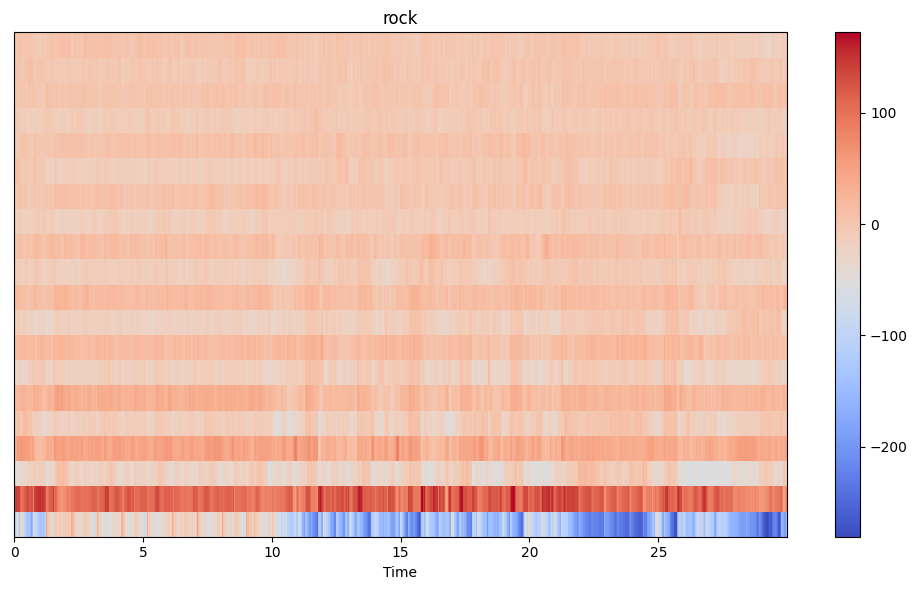

In [5]:
%matplotlib inline

import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_mfcc(title, audio_path):
    y, sr = librosa.load(audio_path, mono=True, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 6))
    img = librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=ax0)
    fig.colorbar(img, ax=ax0)
    ax0.set_title(title)
    fig.tight_layout()
    plt.show()

plot_mfcc("blues", "Data/genres_original/blues/blues.00000.wav")
plot_mfcc("classical","Data/genres_original/classical/classical.00000.wav")
plot_mfcc("country" ,"Data/genres_original/country/country.00000.wav")
plot_mfcc("disco", "Data/genres_original/disco/disco.00000.wav")
plot_mfcc("hiphop", "Data/genres_original/hiphop/hiphop.00000.wav")
plot_mfcc("jazz", "Data/genres_original/jazz/jazz.00000.wav")
plot_mfcc("metal", "Data/genres_original/metal/metal.00000.wav")
plot_mfcc("pop", "Data/genres_original/pop/pop.00000.wav")
plot_mfcc("reggae", "Data/genres_original/reggae/reggae.00000.wav")
plot_mfcc("rock", "Data/genres_original/rock/rock.00000.wav")



# Random Forest

In [6]:
import numpy as np

X = np.load('X.npy')
y_encoded = np.load('y_encoded.npy')

# train model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

# save model
import pickle

with open('random_forest.pkl', 'wb') as f:
    pickle.dump(clf, f)





Accuracy:  0.43


# Neural Networks

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

train_data = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = MusicGenreClassifier(input_size, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy}")


Epoch [1/200], Loss: 4.489486846923828
Epoch [2/200], Loss: 2.3662667083740234
Epoch [3/200], Loss: 2.131702446937561
Epoch [4/200], Loss: 2.0804305553436278
Epoch [5/200], Loss: 1.9690146493911742
Epoch [6/200], Loss: 1.8747358655929565
Epoch [7/200], Loss: 1.829431962966919
Epoch [8/200], Loss: 1.7348934602737427
Epoch [9/200], Loss: 1.7443969917297364
Epoch [10/200], Loss: 1.6564378643035889
Epoch [11/200], Loss: 1.6685246753692626
Epoch [12/200], Loss: 1.6388475465774537
Epoch [13/200], Loss: 1.6273499393463136
Epoch [14/200], Loss: 1.57253080368042
Epoch [15/200], Loss: 1.5454706001281737
Epoch [16/200], Loss: 1.5219275999069213
Epoch [17/200], Loss: 1.5152638244628907
Epoch [18/200], Loss: 1.5106680011749267
Epoch [19/200], Loss: 1.4306283187866211
Epoch [20/200], Loss: 1.4046591854095458
Epoch [21/200], Loss: 1.3769877910614015
Epoch [22/200], Loss: 1.3607026100158692
Epoch [23/200], Loss: 1.4067856979370117
Epoch [24/200], Loss: 1.3790221738815307
Epoch [25/200], Loss: 1.391864

# How a deployment would look like
since the NN only trained on 30 sec segments, in a deployment scenario, I thought I would load the middle 30sec segment, extract it's features and then predict based on that. The `extract_features` function reimplmented here reflects that

In [8]:
%matplotlib inline

import librosa.display
import matplotlib.pyplot as plt
import numpy as np


def load_middle_segment(audio_path, duration=30):
    y, sr = librosa.load(audio_path, mono=True)
    total_duration = len(y) / sr
    middle = total_duration / 2
    offset = middle - (duration / 2)
    offset = max(0, offset)
    y_middle, sr = librosa.load(audio_path, mono=True, offset=offset, duration=duration)
    return y_middle, sr

def extract_features(audio_path):
    y, sr = librosa.load(audio_path)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Extract Tonnetz feature (takes too long to compute)
    # tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # Stack the features, then compute their mean and standard deviation
    features = np.vstack([mfcc, spectral_contrast, chroma])#, tonnetz])
    features_mean = np.mean(features, axis=1)
    features_std = np.std(features, axis=1)

    return np.hstack([features_mean, features_std])

features = extract_features('test_files/test_classical.mp3')
with torch.no_grad():
    out = model(torch.Tensor(features).unsqueeze(0).to(device))
    _, predicted = torch.max(out, 1)


# label_encoder = LabelEncoder()
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))
label = label_encoder.inverse_transform(predicted.cpu().numpy())
print(label)

['classical']
